# 가설 : 보증금 혹은 거래 금액은 상권 수에 영향을 받는다. 

In [62]:

import numpy as np
#import folium
import pandas as pd
#from folium import plugins
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
#from folium.plugins import MarkerCluster
import seaborn as sns

import json
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#예측 라이브러리
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from math import sqrt
import numpy as np
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [63]:
아파트  = pd.read_csv('./data/3.세종시_아파트(매매)_실거래가.csv', encoding='cp949' )
상권 = pd.read_csv('./data/14.세종시_상권정보.csv')
세대수 = pd.read_csv('./data/28.세종시_지역별_세대원수별_세대수.csv', encoding='cp949' )
가구소득 = pd.read_csv('./data/27.세종시_월평균_가구소득.csv', encoding='cp949' )
업종코드 = pd.read_csv('./data/15.세종시_상권정보_업종코드.csv')

In [64]:
def 전처리(부동산): # 파일명 3,4,6번 만 가능
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','전용면적(㎡)','거래금액(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    
    return 부동산_세대수

In [65]:
def 랜덤서치(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '거래금액(만원)', '건축년도', '1인', '2인', '3인', '4인', '5인',
       '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P', 'Q',
       'R']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['거래금액(만원)']]
    X= X_scaled.drop('거래금액(만원)',axis=1)
    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }


   

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


# 예측 모델

Best score: -0.002792648829825639
Best model: {'max_depth': 11, 'max_features': 13, 'n_estimators': 143}
X_train,y_train Accuracy: 84.66%
X_test,y_test Accuracy: 83.16%
y_test,pred Mse 0.034043549248270036
y_test,pred SQRT Mse 0.05190358350492426


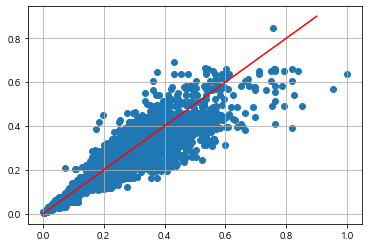

<Figure size 504x288 with 0 Axes>

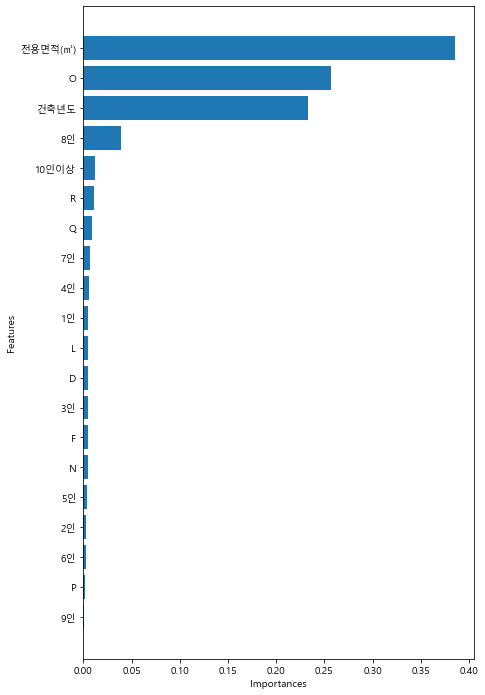

In [66]:
연립다세대 = pd.read_csv('./data/3.세종시_아파트(매매)_실거래가.csv', encoding='cp949') #라쏘 
랜덤서치(전처리(연립다세대)) #오피스텔 편의가 필요 

Best score: -0.003112837600937927
Best model: {'max_depth': 19, 'max_features': 11, 'n_estimators': 72}
X_train,y_train Accuracy: 94.73%
X_test,y_test Accuracy: 89.22%
y_test,pred Mse 0.025255882803287968
y_test,pred SQRT Mse 0.049121774342569736


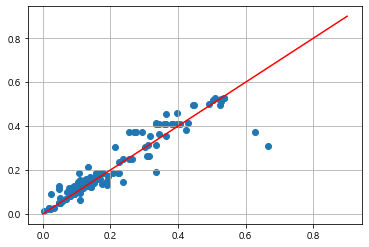

<Figure size 504x288 with 0 Axes>

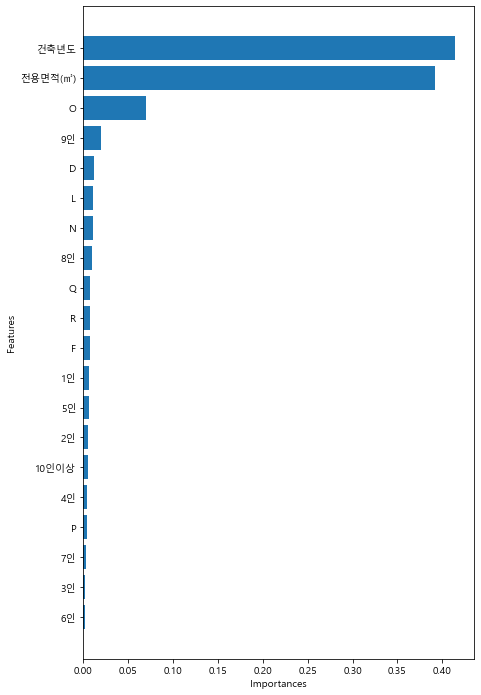

In [67]:
연립다세대 = pd.read_csv('./data/4.세종시_연립다세대(매매)_실거래가.csv', encoding='cp949') #빌라
랜덤서치(전처리(연립다세대))

Best score: -0.005501471453021009
Best model: {'max_depth': 8, 'max_features': 18, 'n_estimators': 104}
X_train,y_train Accuracy: 87.46%
X_test,y_test Accuracy: 58.5%
y_test,pred Mse 0.06563561729094496
y_test,pred SQRT Mse 0.09220300043699634


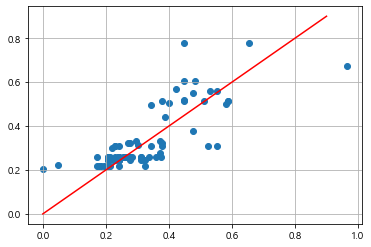

<Figure size 504x288 with 0 Axes>

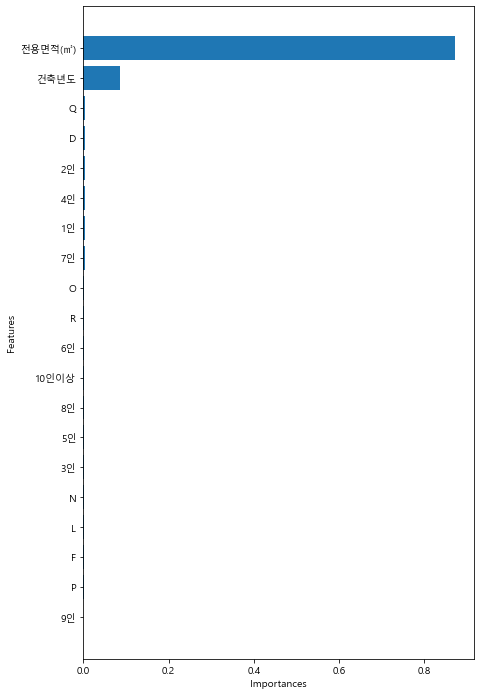

In [68]:
연립다세대 = pd.read_csv('./data/6.세종시_오피스텔(매매)_실거래가.csv', encoding='cp949')
랜덤서치(전처리(연립다세대))

In [69]:
def 전처리2(부동산): # 파일 5번만
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','대지면적(㎡)','연면적(㎡)','도로조건','주택유형','거래금액(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['주택유형','도로조건'])
    
    return 부동산_세대수

def 랜덤서치2(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['대지면적(㎡)', '연면적(㎡)', '거래금액(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '주택유형_다가구', '주택유형_단독', '도로조건_-', '도로조건_12m미만', '도로조건_25m미만',
       '도로조건_25m이상', '도로조건_8m미만']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['거래금액(만원)']]
    X= X_scaled.drop('거래금액(만원)',axis=1)
    
    
    
    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


Best score: -0.0018473755027916517
Best model: {'max_depth': 12, 'max_features': 16, 'n_estimators': 82}
X_train,y_train Accuracy: 96.13%
X_test,y_test Accuracy: 66.12%
y_test,pred Mse 0.03135912804845423
y_test,pred SQRT Mse 0.061491775814701576


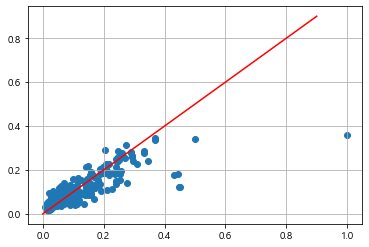

<Figure size 504x288 with 0 Axes>

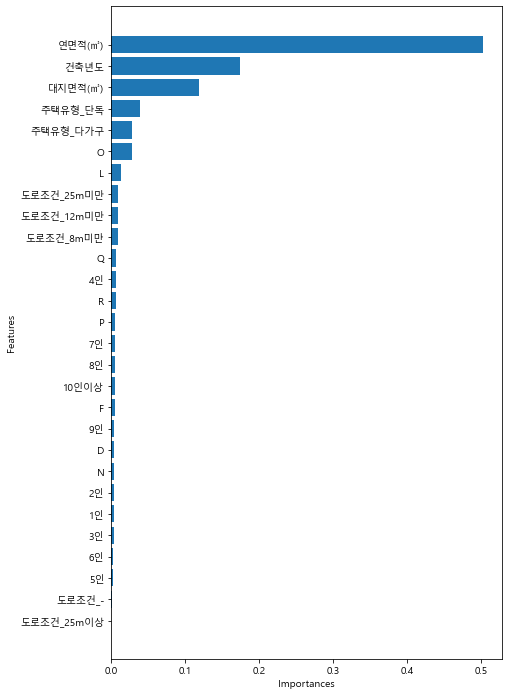

In [70]:
단독다가구 = pd.read_csv('./data/5.세종시_단독다가구(매매)_실거래가.csv', encoding='cp949')
랜덤서치2(전처리2(단독다가구))

In [71]:
def 전처리3(부동산): 
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','전용면적(㎡)','전월세구분','보증금(만원)','월세(만원)','층','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['전월세구분','층'])
    
    return 부동산_세대수


In [72]:
def 랜덤서치3(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_-1', '층_1', '층_2', '층_3', '층_4',
       '층_5', '층_6', '층_7', '층_8', '층_9', '층_10', '층_11', '층_12', '층_13',
       '층_14', '층_15', '층_16', '층_17', '층_18', '층_19', '층_20', '층_21', '층_22',
       '층_23', '층_24', '층_25', '층_26', '층_27', '층_28', '층_29', '층_30', '층_31',
       '층_32', '층_33']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   
    
    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


Best score: -0.0025457446724622677
Best model: {'max_depth': 17, 'max_features': 19, 'n_estimators': 63}
X_train,y_train Accuracy: 88.28%
X_test,y_test Accuracy: 83.02%
y_test,pred Mse 0.03257029059776794
y_test,pred SQRT Mse 0.05032289610634758


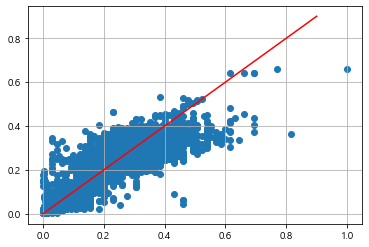

<Figure size 504x288 with 0 Axes>

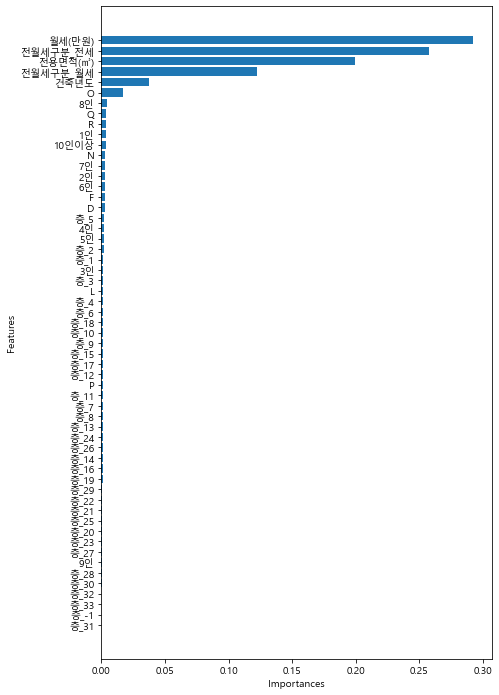

In [73]:
단독다가구 = pd.read_csv('./data/7.세종시_아파트(전월세)_실거래가.csv', encoding='cp949')
랜덤서치3(전처리3(단독다가구))


In [74]:
def 랜덤서치4(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[['전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_-1', '층_1', '층_2', '층_3', '층_4',
       '층_5', '층_6', '층_7', '층_8']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


Best score: -0.00731186837042751
Best model: {'max_depth': 19, 'max_features': 15, 'n_estimators': 190}
X_train,y_train Accuracy: 97.11%
X_test,y_test Accuracy: 76.28%
y_test,pred Mse 0.0496608704049944
y_test,pred SQRT Mse 0.08537384894025656


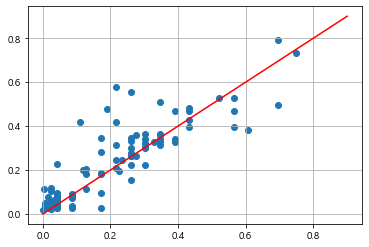

<Figure size 504x288 with 0 Axes>

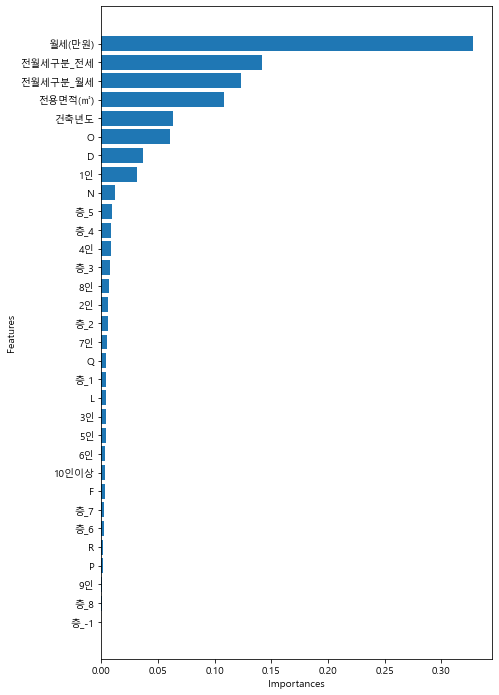

In [75]:
단독다가구 = pd.read_csv('./data/8.세종시_연립다세대(전월세)_실거래가.csv', encoding='cp949')
랜덤서치4(전처리3(단독다가구))

In [76]:
def 전처리4(부동산): # 파일 5번만
    
    #상권대분류 전처리
    상권_대분류 = 상권.groupby(['행정동명','상권업종대분류코드']).count()
    상권_대분류 = 상권_대분류[['lon']]
    상권_대분류.rename(columns = {"lon":"count"},inplace=True)
    상권_대분류= 상권_대분류.reset_index()
    상권대분류_피벗 = pd.pivot_table(상권_대분류, index=['행정동명'], columns=['상권업종대분류코드'])
    상권대분류_피벗 = 상권대분류_피벗['count']
    상권대분류_피벗.columns.name = None 
    #아파트 전처리
    부동산 = 부동산[['시군구','계약면적(㎡)','도로조건','전월세구분','보증금(만원)','월세(만원)','건축년도']]
    부동산['읍면동']= 부동산['시군구'].str.split(" ").str[1]
    #세대수 전처리
    세대수['읍면동'] = 세대수['읍면동'].str.replace(' ', "")
    try :
        del 세대수['계']
    except :
        pass
    #아프트_세대수 변수 생성
    부동산_세대수 = 부동산.merge(세대수, on='읍면동', how='left')
    부동산_세대수 = 부동산_세대수.merge(상권대분류_피벗, left_on = '읍면동',  right_on= '행정동명', how='left')
    del 부동산_세대수['읍면동']
    부동산_세대수 = 부동산_세대수.fillna(0)
    부동산_세대수['건축년도'] = 2021- 부동산_세대수['건축년도']
    부동산_세대수 = pd.get_dummies(부동산_세대수, columns=['전월세구분','도로조건'])
    
    return 부동산_세대수


In [77]:
def 랜덤서치5(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[[ '계약면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '도로조건_-', '도로조건_12m미만', '도로조건_25m미만',
       '도로조건_25m이상', '도로조건_8m미만']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   

    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


Best score: -0.0008753282201764212
Best model: {'max_depth': 10, 'max_features': 12, 'n_estimators': 89}
X_train,y_train Accuracy: 90.71%
X_test,y_test Accuracy: 77.09%
y_test,pred Mse 0.01576042607837237
y_test,pred SQRT Mse 0.033132577820334935


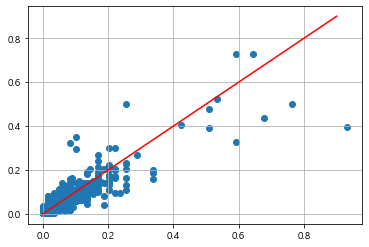

<Figure size 504x288 with 0 Axes>

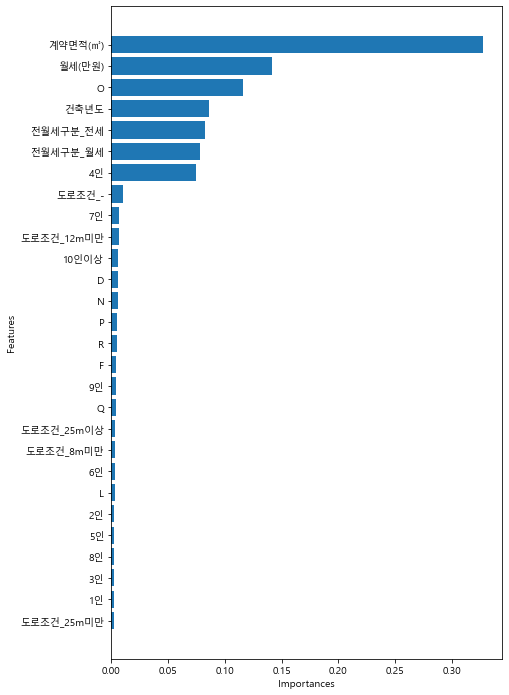

In [78]:
단독다가구 = pd.read_csv('./data/9.세종시_단독다가구(전월세)_실거래가.csv', encoding='cp949')
랜덤서치5(전처리4(단독다가구))

In [79]:
def 랜덤서치6(부동산):    
    try:
        부동산['거래금액(만원)'] = 부동산['거래금액(만원)'].str.replace(",","")
        부동산['거래금액(만원)'].astype('int64')
    
    except:
        pass
    
    x_num= 부동산[[ '전용면적(㎡)', '보증금(만원)', '월세(만원)', '건축년도', '1인', '2인', '3인', '4인',
       '5인', '6인', '7인', '8인', '9인', '10인이상', 'D', 'F', 'L', 'N', 'O', 'P',
       'Q', 'R', '전월세구분_월세', '전월세구분_전세', '층_2', '층_3', '층_4', '층_5', '층_6',
       '층_7', '층_8', '층_9', '층_10', '층_11', '층_12', '층_13', '층_14', '층_15',
       '층_16', '층_17', '층_18', '층_19', '층_20']]
    
    

    scaler = MinMaxScaler()
    scaler.fit(x_num)
    X_scaled = scaler.transform(x_num)
    X_scaled = pd.DataFrame(X_scaled, index=x_num.index, columns=x_num.columns)
    #X = pd.concat([X_scaled, x_cat], axis=1)
    y =X_scaled[['보증금(만원)']]
    X= X_scaled.drop('보증금(만원)',axis=1)
   
    param_distribs = { 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=21),
                      'max_depth':randint(low=5, high=20) }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    rnd_search = RandomizedSearchCV(rf, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42) 
    rnd_search.fit(X_train, y_train)
    
    print(f'Best score: {rnd_search.best_score_}')
    print(f'Best model: {rnd_search.best_params_}')
    pipe = rnd_search.best_estimator_

    print("X_train,y_train Accuracy: {}%".format(round(pipe.score(X_train, y_train)*100, 2)))
    print("X_test,y_test Accuracy: {}%".format(round(pipe.score(X_test, y_test)*100, 2)))
    # get the predicitons from the random forest object
    y_pred = pipe.predict(X_test)
    print("y_test,pred Mse",mean_absolute_error(y_test, y_pred))
    print("y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, y_pred)))    
    features = np.array(X_test.columns)
    # get the feature importances
    importances = pipe.feature_importances_
    # sort the indexes
    sorted_index = np.argsort(importances)
    sorted_importances = importances[sorted_index]
    sorted_features = features[sorted_index]
    # plot the explained variance using a barplot
    plt.grid(True)
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([0, 0.9], [0, 0.9], 'r-')
    plt.figure(figsize=(7, 4))
    plt.show()
    
    plt.figure(figsize=(7, 12))
    plt.barh(sorted_features , sorted_importances)
    
    plt.xlabel('Importances')
    plt.ylabel('Features')
    plt.show()
    


Best score: -0.002279751431154132
Best model: {'max_depth': 11, 'max_features': 9, 'n_estimators': 15}
X_train,y_train Accuracy: 98.26%
X_test,y_test Accuracy: 97.05%
y_test,pred Mse 0.024856891751340524
y_test,pred SQRT Mse 0.042408026825100587


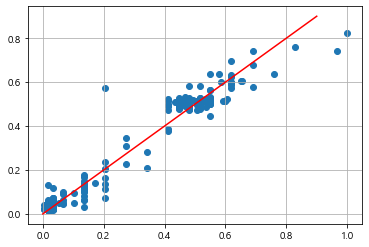

<Figure size 504x288 with 0 Axes>

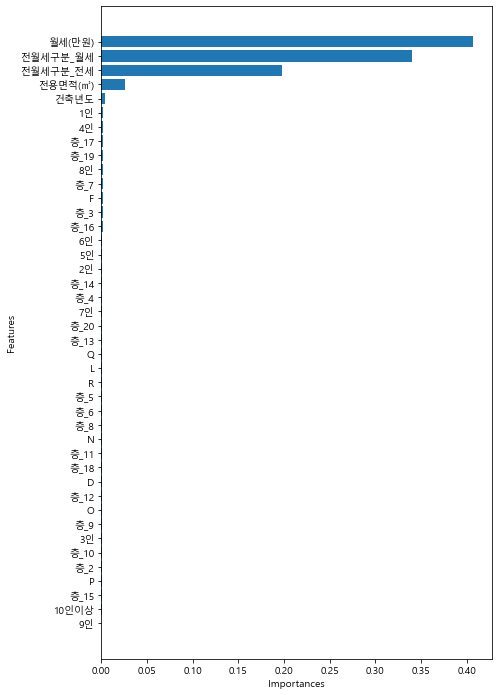

In [80]:
단독다가구 = pd.read_csv('./data/10.세종시_오피스텔(전월세)_실거래가.csv', encoding='cp949')
랜덤서치6(전처리3(단독다가구))